In [78]:
import pandas as pd
from plotly import express as px
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv("./consumer_electronics_sales_data.csv");
data.head()

,ProductID,ProductCategory,ProductBrand,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent
0,5874,Smartphones,Other Brands,312.949668,18,0,2,1,0
1,5875,Smart Watches,Samsung,980.389404,35,1,7,2,1
2,5876,Tablets,Samsung,2606.718293,63,0,1,5,1
3,5877,Smartphones,Samsung,870.395450,63,1,10,3,1
4,5878,Tablets,Sony,1798.955875,57,0,17,3,0


In [3]:
data.drop(columns='ProductID', inplace=True)

In [4]:
data.isnull().sum()

ProductCategory         0
ProductBrand            0
ProductPrice            0
CustomerAge             0
CustomerGender          0
PurchaseFrequency       0
CustomerSatisfaction    0
PurchaseIntent          0
dtype: int64

In [5]:
data[data.duplicated()]

,ProductCategory,ProductBrand,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent


In [6]:
data.describe()

,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,1527.429195,43.347000,0.508889,10.054667,2.996000,0.566444
std,829.900898,15.055084,0.499949,5.461328,1.405301,0.495593
min,100.376358,18.000000,0.000000,1.000000,1.000000,0.000000
25%,809.165014,30.000000,0.000000,5.000000,2.000000,0.000000
50%,1513.024577,43.000000,1.000000,10.000000,3.000000,1.000000
75%,2244.415520,56.000000,1.000000,15.000000,4.000000,1.000000
max,2999.852253,69.000000,1.000000,19.000000,5.000000,1.000000


## EDA

In [7]:
PurchaseIntent_count = data['PurchaseIntent'].value_counts().reset_index()
PurchaseIntent_count.columns = ['PurchaseIntent', 'Count']

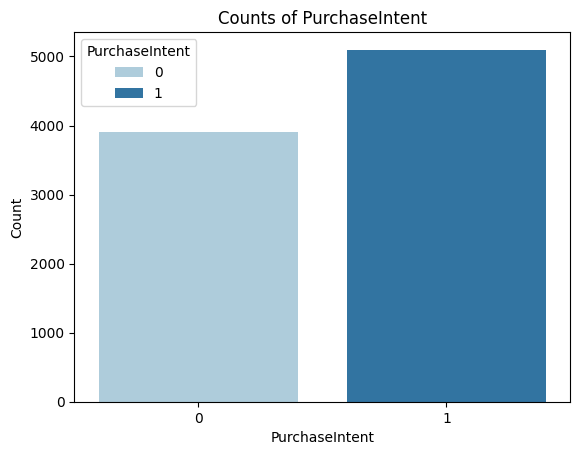

In [11]:
sns.barplot(data=PurchaseIntent_count, x='PurchaseIntent', y='Count', hue='PurchaseIntent', dodge=False, palette='Paired')
plt.title('Counts of PurchaseIntent')
plt.xlabel('PurchaseIntent')
plt.ylabel('Count')
plt.legend(title='PurchaseIntent')
plt.show()

In [18]:
CustomerGender_labels = {0:"Male", 1:"Female"}
CustomerGender_values = data['CustomerGender'].value_counts().reset_index()
CustomerGender_values.columns = ['CustomerGender', 'Count']
CustomerGender_values['CustomerGender'] = CustomerGender_values['CustomerGender'].map(CustomerGender_labels)
CustomerGender_values

,CustomerGender,Count
0,Female,4580
1,Male,4420


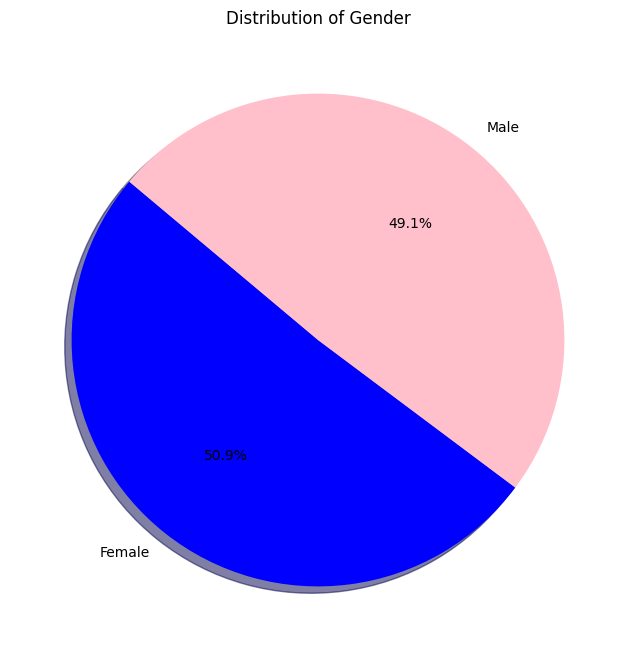

In [25]:
colors = ['blue', 'pink']
plt.figure(figsize=(10, 8))
plt.pie(CustomerGender_values['Count'], labels=CustomerGender_values['CustomerGender'], colors=colors, shadow=True, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Gender")
plt.show()

In [38]:
data.head(2)

,ProductCategory,ProductBrand,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent,PriceRange,AgeRange
0,Smartphones,Other Brands,312.949668,18,0,2,1,0,200-500,0-20
1,Smart Watches,Samsung,980.389404,35,1,7,2,1,500-1000,20-50


C:\Users\muham\AppData\Local\Temp\ipykernel_7760\3763094682.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='CustomerGender', palette='viridis')


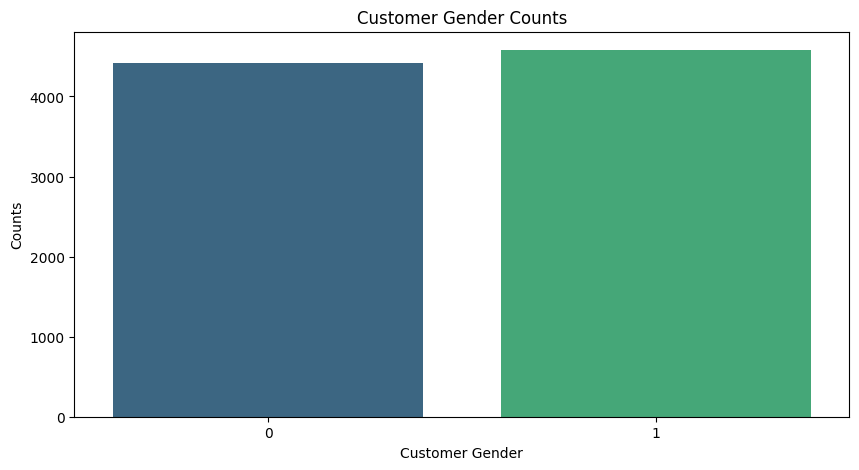

In [40]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='CustomerGender', palette='viridis')
plt.title("Customer Gender Counts")
plt.xlabel("Customer Gender"); plt.ylabel("Counts");plt.show()

<Axes: xlabel='ProductPrice', ylabel='Count'>

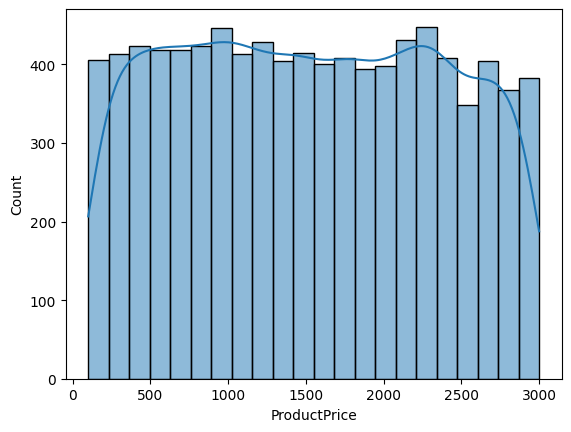

In [55]:
sns.histplot(data=data['ProductPrice'], kde=True)

Text(0.5, 1.0, 'Age Distribution')

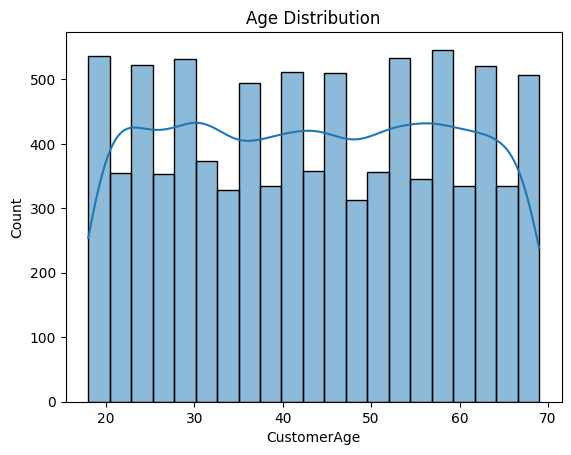

In [41]:
sns.histplot(data=data['CustomerAge'], kde=True)
plt.title("Age Distribution")

In [29]:
data['ProductPrice'].describe()

count    9000.000000
mean     1527.429195
std       829.900898
min       100.376358
25%       809.165014
50%      1513.024577
75%      2244.415520
max      2999.852253
Name: ProductPrice, dtype: float64

In [32]:
price_bins = [1, 200, 500, 1000, float('inf')]
price_labels = ['1-200', '200-500', '500-1000', '1000+']
age_bins = [0, 20, 50, float('inf')]
age_labels = ['0-20', '20-50', '50+']

data['PriceRange'] = pd.cut(data['ProductPrice'], bins=price_bins, labels=price_labels, right=False)
data['AgeRange'] = pd.cut(data['CustomerAge'], bins=age_bins, labels=age_labels, right=False)

In [33]:
data

,ProductCategory,ProductBrand,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent,PriceRange,AgeRange
0,Smartphones,Other Brands,312.949668,18,0,2,1,0,200-500,0-20
1,Smart Watches,Samsung,980.389404,35,1,7,2,1,500-1000,20-50
2,Tablets,Samsung,2606.718293,63,0,1,5,1,1000+,50+
3,Smartphones,Samsung,870.395450,63,1,10,3,1,500-1000,50+
4,Tablets,Sony,1798.955875,57,0,17,3,0,1000+,50+
...,...,...,...,...,...,...,...,...,...,...
8995,Smart Watches,Samsung,1041.149163,36,1,16,4,0,1000+,20-50
8996,Smartphones,Samsung,1485.694311,57,0,5,1,1,1000+,50+
8997,Headphones,Samsung,2887.369597,28,0,18,4,0,1000+,20-50
8998,Tablets,HP,1490.453964,38,0,4,2,1,1000+,20-50


C:\Users\muham\AppData\Local\Temp\ipykernel_7760\1005041968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='PriceRange', palette='viridis')


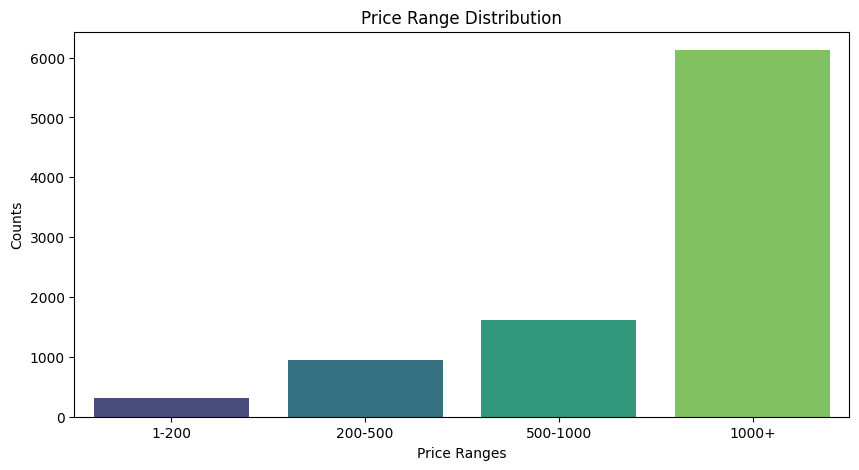

In [42]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='PriceRange', palette='viridis')
plt.title("Price Range Distribution")
plt.xlabel("Price Ranges"); plt.ylabel("Counts");plt.show()

C:\Users\muham\AppData\Local\Temp\ipykernel_7760\3368318852.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='AgeRange', palette='viridis')


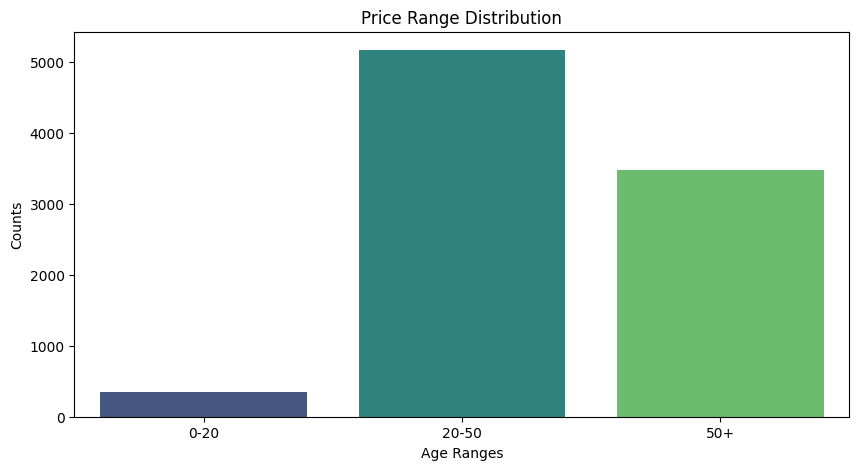

In [43]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='AgeRange', palette='viridis')
plt.title("Price Range Distribution")
plt.xlabel("Age Ranges"); plt.ylabel("Counts");plt.show()

Now Lets try to build a prediction model, where if a customer's age is known and we know there budget i.e., price range then we should predict which Product Brand and which product category are they most likely to shop from.

In [49]:
le_ProductCategory = LabelEncoder()

In [50]:
data['ProductCategory'] = le_ProductCategory.fit_transform(data['ProductCategory'])

In [52]:
le_ProductBrand	 = LabelEncoder()
data['ProductBrand'] = le_ProductBrand.fit_transform(data['ProductBrand'])
data.head()

,ProductCategory,ProductBrand,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent,PriceRange,AgeRange
0,3,2,312.949668,18,0,2,1,0,200-500,0-20
1,2,3,980.389404,35,1,7,2,1,500-1000,20-50
2,4,3,2606.718293,63,0,1,5,1,1000+,50+
3,3,3,870.395450,63,1,10,3,1,500-1000,50+
4,4,4,1798.955875,57,0,17,3,0,1000+,50+


In [56]:
data.columns

Index(['ProductCategory', 'ProductBrand', 'ProductPrice', 'CustomerAge',
       'CustomerGender', 'PurchaseFrequency', 'CustomerSatisfaction',
       'PurchaseIntent', 'PriceRange', 'AgeRange'],
      dtype='object')

In [69]:
X = data[['ProductCategory', 'ProductBrand', 'ProductPrice', 'CustomerAge',
       'CustomerGender', 'PurchaseFrequency', 'CustomerSatisfaction']]
y = data['PurchaseIntent']

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)
X_transformed

array([[ 0.70802927, -0.00741153, -1.46348438, ..., -1.01793865,
        -1.4749369 , -1.42041549],
       [-0.00483161,  0.70220269, -0.65919941, ...,  0.98237747,
        -0.5593578 , -0.70878448],
       [ 1.42089015,  0.70220269,  1.30057585, ..., -1.01793865,
        -1.65805273,  1.42610854],
       ...,
       [-1.43055337,  0.70220269,  1.63876912, ..., -1.01793865,
         1.45491624,  0.71447753],
       [ 1.42089015, -0.71702574, -0.04455627, ..., -1.01793865,
        -1.10870526, -0.70878448],
       [ 0.70802927,  1.4118169 ,  0.94974916, ..., -1.01793865,
         0.90556878, -0.70878448]])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=42)

In [76]:
models = {
        'Logistic Regression' :LogisticRegression(random_state=42),
        'SVC': SVC(probability=True, kernel='linear'),
        'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
        'XGB Classifier': XGBClassifier(),
        'K Neighbors Classifier': KNeighborsClassifier(),
        'Random Forest Classifier':RandomForestClassifier(n_jobs=-1, n_estimators=103)
}

Model: Logistic Regression
Accuracy: 0.8497777777777777
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       988
           1       0.86      0.88      0.87      1262

    accuracy                           0.85      2250
   macro avg       0.85      0.85      0.85      2250
weighted avg       0.85      0.85      0.85      2250





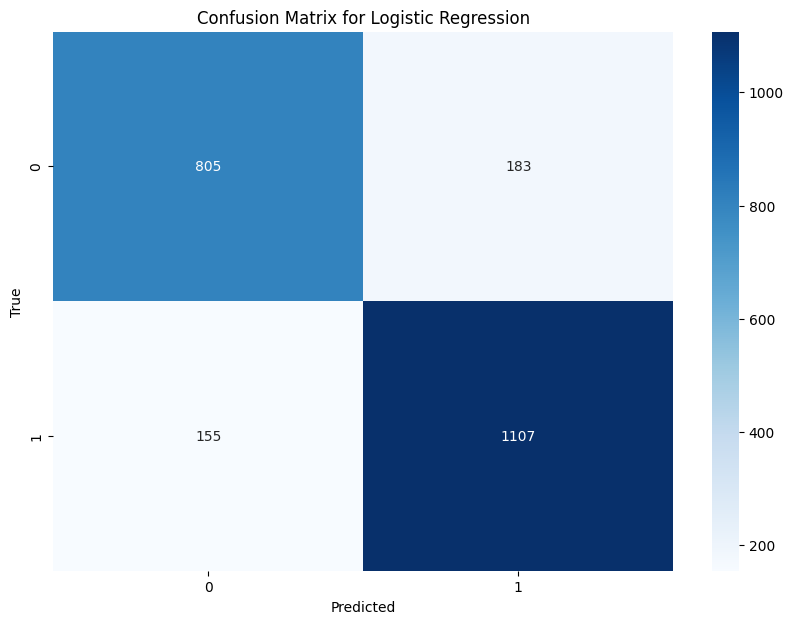

Model: SVC
Accuracy: 0.8475555555555555
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       988
           1       0.86      0.87      0.86      1262

    accuracy                           0.85      2250
   macro avg       0.85      0.84      0.84      2250
weighted avg       0.85      0.85      0.85      2250





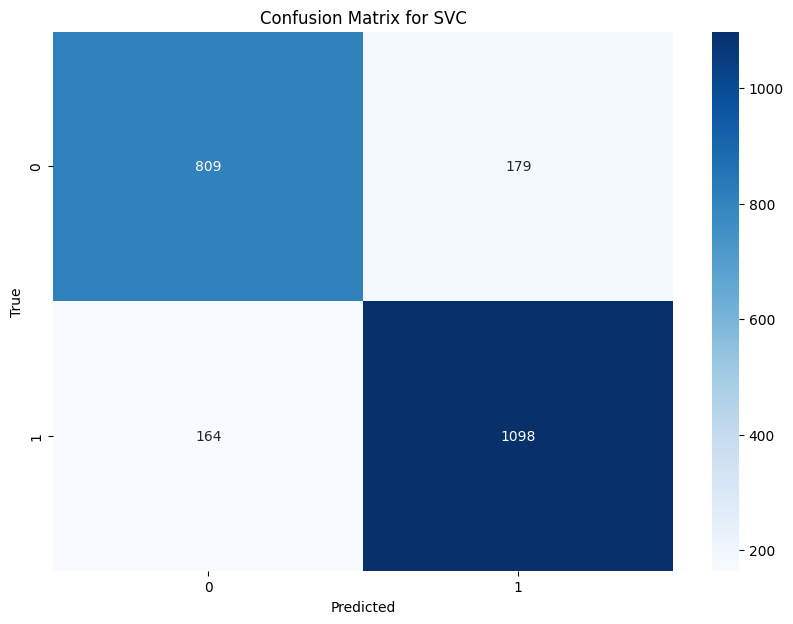

Model: Gradient Boosting Classifier
Accuracy: 0.9502222222222222
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       988
           1       0.95      0.97      0.96      1262

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250





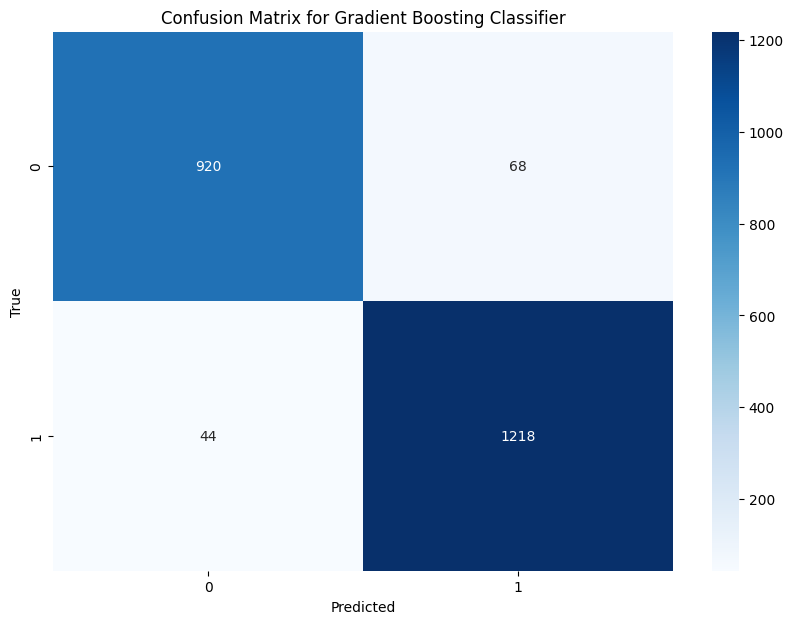

Model: XGB Classifier
Accuracy: 0.9497777777777778
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       988
           1       0.95      0.96      0.96      1262

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250





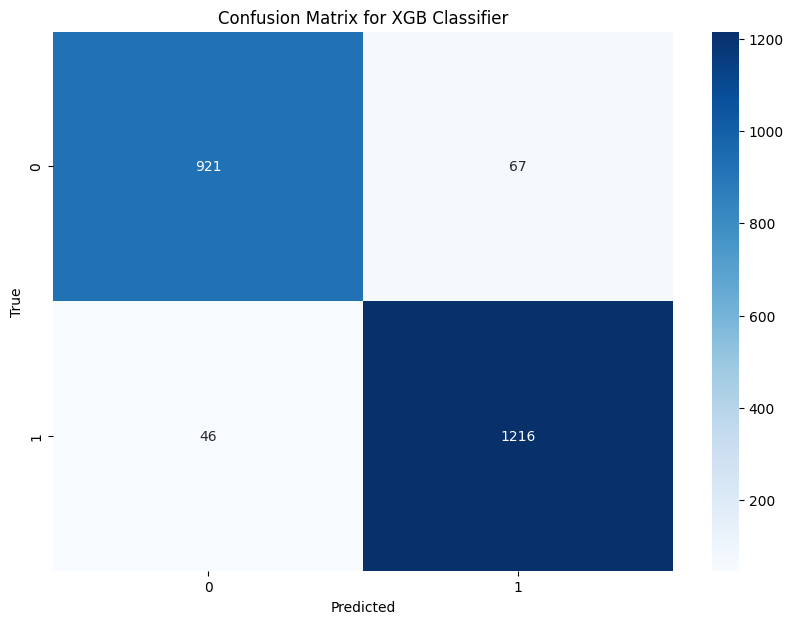

Model: K Neighbors Classifier
Accuracy: 0.9146666666666666
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       988
           1       0.92      0.93      0.92      1262

    accuracy                           0.91      2250
   macro avg       0.91      0.91      0.91      2250
weighted avg       0.91      0.91      0.91      2250





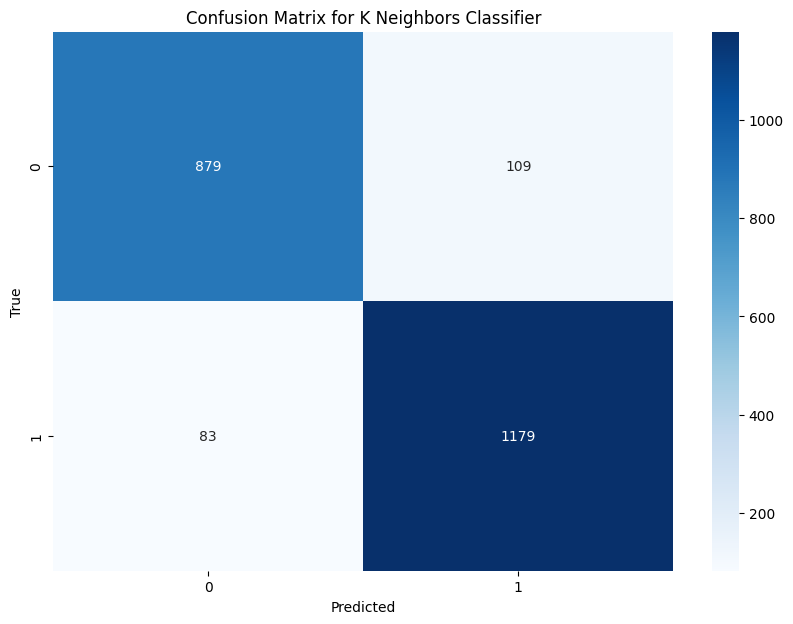

Model: Random Forest Classifier
Accuracy: 0.9511111111111111
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       988
           1       0.95      0.97      0.96      1262

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250





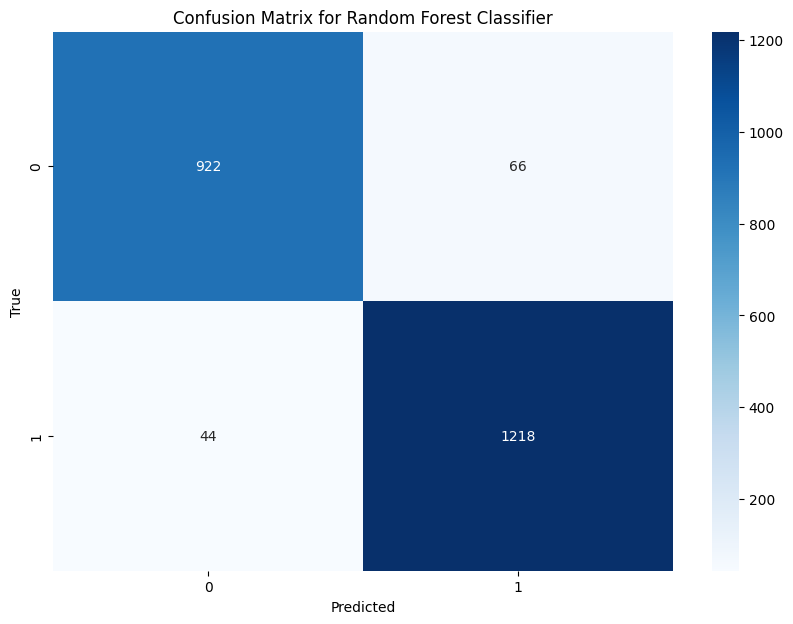

In [82]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {name}")
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    
    confusionMatrix = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
    print(classification_report(y_true=y_test, y_pred=y_pred))
    print("\n")
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()